# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), and evaluating your model's results (task 3).

Please upload your solved notebook to Moodle (under [Milestone 4 Submission](https://moodle.epfl.ch/mod/assign/view.php?id=1199557)) adding your team name in title, example: `m4-lernnavi-teamname.ipynb`. Please run all cells before submission so we can grade effectively.



## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection, metrics

# PyBKT package imports
from pyBKT.models import Model

# PyAFM package imports
from pyafm.custom_logistic import CustomLogistic

DATA_DIR = 'data' # You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [2]:
topics=pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))
topics_trees=pd.read_csv('{}/topic_trees.csv.gz'.format(DATA_DIR))
documents=pd.read_csv('{}/documents.csv.gz'.format(DATA_DIR))
learn_sessions=pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))

In [3]:
transactions['user_id']=transactions['user_id'].astype(int)

## Task 0: Research Question

**Research question:**
*Your chosen research question goes here*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

Different approaches we have to try:

1. Ways of considering partial answers:
    -a as 1 (correct)
    - as 0 (incorrect)
    - as -1 (not answered)-the least logical
    - as 1 if answered >50% correct,0 otherwise
    
2. Answers:
    - can be given only on tasks of type 'level check'
    - can be given on all types of tasks

3. Acceptance of session:
    - consider only accepted sessions
    - consider 
    
4. Closeness of session:
    - closed
    - any

5. Filter users:
    - allow any number of sessions
    - only users with many sessions

In [4]:
learn_transaction=pd.merge(learn_sessions,transactions[['transaction_id','user_id','evaluation']],on='transaction_id').copy()

In [5]:
#We assume that answers can be given only on tasks of lype check and no answers on tasks of type learn
learn_transaction=learn_transaction[((learn_transaction['type_id']==2)  & (learn_transaction['evaluation'].notna())) | ((learn_transaction['type_id']==1)  & (learn_transaction['evaluation'].isna()))].copy()

In [6]:
learn_transaction['correct']=learn_transaction['evaluation'].fillna(-1) #not given
learn_transaction['correct']=np.where((learn_transaction['correct']=='CORRECT') ,1,np.where(learn_transaction['correct']==-1,-1,0)) #PARTIAL as incorrect
#learn_transaction['correct']=np.where((learn_transaction['correct']=='CORRECT') & (learn_transaction['correct']=='PARTIAL'),1,np.where(learn_transaction['correct']==-1,-1,0)) #PARTIAL as correct

In [7]:
learn_transaction=pd.merge(learn_transaction,topics,left_on='topic_id',right_on='id').copy()

In [8]:
learn_transaction=learn_transaction[learn_transaction['is_accepted']==1].reset_index().copy()

In [9]:
learn_transaction['subject']=np.where(learn_transaction['math']==1,'Math','German')

In [10]:
df_topic=learn_transaction[['user_id','learn_session_id','transaction_id','name_english','correct']].sort_values(by=['learn_session_id','transaction_id'],ascending=True)
df_topic=df_topic.rename(columns={"name_english": "skill_name"}).copy()

In [11]:
df_topic['prior_success']=np.where(df_topic.correct==1,1,0)
df_topic['prior_failure']=np.where(df_topic.correct==0,1,0)
df_topic['prior_success']=df_topic.groupby(['user_id','skill_name']).prior_success.cumsum()-1
df_topic['prior_success']=df_topic['prior_success'].apply(lambda x: 0 if x<0 else x)
df_topic['prior_failure']=df_topic.groupby(['user_id','skill_name']).prior_failure.cumsum()-1
df_topic['prior_failure']=df_topic['prior_failure'].apply(lambda x: 0 if x<0 else x)

In [12]:
#Take top 10 topics to analyze over them
top_topics=df_topic.groupby('skill_name').count().sort_values(by='user_id',ascending=False)[-20:].index

In [13]:
top_topics

Index(['Content of minor sets', 'Centric stretch and similarity',
       'Congress between phrases', 'Absolute amount',
       'Comma in sanctars and supplements', 'Evidence by congruence',
       'Connectors', 'Switching formulas', 'Inequality',
       'General triangles, sinus and cosine',
       'Sentence group of the Pythagoras', 'Circle and circle parts',
       'Gray equations that lead to linear equations',
       'Text tasks on linear equations', 'Elemental geometry - basics',
       'Macrostructure', 'Translations of functional graphs',
       'Relationship between phrases / attributes and sidelines',
       'Functional values ​​of sinus, cosinus, tangens',
       'Bowmass - Definition, Conversions in GradeMass and values ​​of trigonometric functions'],
      dtype='object', name='skill_name')

In [14]:
df_topic=df_topic[df_topic['skill_name'].isin(top_topics)].reset_index(drop=True)
df_topic

,user_id,learn_session_id,transaction_id,skill_name,correct,prior_success,prior_failure
0,387605,5432,387905,Connectors,-1,0,0
1,387605,5433,387906,Congress between phrases,-1,0,0
2,387615,5557,388232,Connectors,-1,0,0
3,387655,5595,388404,Comma in sanctars and supplements,-1,0,0
4,387655,5665,388714,Comma in sanctars and supplements,-1,0,0
...,...,...,...,...,...,...,...
3827,404578,111920,1582978,Evidence by congruence,0,8,4
3828,404578,111920,1582990,Evidence by congruence,1,9,4
3829,404578,111920,1582991,Evidence by congruence,0,9,5
3830,404578,111920,1582997,Evidence by congruence,1,10,5


In [15]:
# user_activity=df_topic.groupby('user_id').count().sort_values(by='correct').copy()
# include_users=user_activity.index.to_frame().sample(1000).index #random 2500 of users
# df_topic=df_topic[df_topic['user_id'].isin(include_users)].copy()

In [16]:
# df_topic = df_topic.iloc[:25000,:]
df_topic

,user_id,learn_session_id,transaction_id,skill_name,correct,prior_success,prior_failure
0,387605,5432,387905,Connectors,-1,0,0
1,387605,5433,387906,Congress between phrases,-1,0,0
2,387615,5557,388232,Connectors,-1,0,0
3,387655,5595,388404,Comma in sanctars and supplements,-1,0,0
4,387655,5665,388714,Comma in sanctars and supplements,-1,0,0
...,...,...,...,...,...,...,...
3827,404578,111920,1582978,Evidence by congruence,0,8,4
3828,404578,111920,1582990,Evidence by congruence,1,9,4
3829,404578,111920,1582991,Evidence by congruence,0,9,5
3830,404578,111920,1582997,Evidence by congruence,1,10,5


In [17]:
np.shape(df_topic)

(3832, 7)

*Your discussion about your processing decisions goes here*

## Task 2: Model Building
----
In this section, we will perform: 

(i) a Bayesian Knowledge Tracing (BKT) model, 

(ii) an Additive Factor Model (AFM),

(iii) a Performance Factor Analysis (PFA) model and 

(iv) a Deep learning knowledge tracing (DKT) model <br>
on the skills 'Math', and 'German' for subject dataframe and 'Large and lower case', 'Spelling principles', 'Comma in enumerations', 'Verb', 'noun', 'Comma in sentence','Separate and grouping', 'Spellishly difficult words','vocabulary', and 'Particle' for topic dataframe

We will complete this section through four main tasks:

Task 2.1: Group k-fold initialization.

Task 2.2: BKT evaluation.

Task 2.3: AFM evaluation.

Task 2.4: PFA evaluation.

Task 2.5: DKT evaluation.

We take a look at the skills included in the data set:

In [18]:
df_topic['skill_name'].unique()

array(['Connectors', 'Congress between phrases',
       'Comma in sanctars and supplements',
       'Translations of functional graphs', 'Switching formulas',
       'Inequality', 'Absolute amount',
       'Relationship between phrases / attributes and sidelines',
       'Sentence group of the Pythagoras', 'Elemental geometry - basics',
       'Circle and circle parts', 'Evidence by congruence',
       'Functional values \u200b\u200bof sinus, cosinus, tangens',
       'General triangles, sinus and cosine', 'Macrostructure',
       'Centric stretch and similarity',
       'Gray equations that lead to linear equations',
       'Text tasks on linear equations',
       'Bowmass - Definition, Conversions in GradeMass and values \u200b\u200bof trigonometric functions',
       'Content of minor sets'], dtype=object)

### Task 2.1

In [19]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data in 3 folds, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupKFold(n_splits=3).split(X, groups=groups)

Let's check the output of this function and a few properties of the iterator.

In [20]:
tested_user_ids = set()
for iteration, (train_index, test_index) in enumerate(create_iterator(df_topic)):
    user_ids = df_topic['user_id'].unique()
    train_user_ids = df_topic.iloc[train_index]['user_id'].unique()
    test_user_ids = df_topic.iloc[test_index]['user_id'].unique()
    print('Iteration:', iteration)
    print('Intersection between train and test user ids:', set(train_user_ids) & set(test_user_ids))
    print('All user ids in train and test user union:', len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids))
    print('User ids tested more than once:', set(tested_user_ids) & set(test_user_ids))
    tested_user_ids = tested_user_ids.union(set(test_user_ids))

Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()
Iteration: 1
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()
Iteration: 2
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()


On a given iteration, no user appears in both training and test sets. The union of the users in both training and test sets given us the full set of user ids in the dataset. Each user appears in the test set exactly once.

### Task 2.2

In this task we evaluate a `BKT model` with all default parameters in pyBKT, through a `3-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [21]:
rmse_bkt, auc_bkt = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_topic)):
    
    # Split data in training and test sets
    X_train, X_test = df_topic.iloc[train_index], df_topic.iloc[test_index]
    
    # Initialize and fit the model
    model = Model(seed=0)
    %time model.fit(data=X_train) 
    
    # Compute RMSE
    train_rmse = model.evaluate(data=X_train, metric='rmse')
    test_rmse = model.evaluate(data=X_test, metric='rmse')
    rmse_bkt.append(test_rmse)
    
    # Compute AUC
    train_auc = model.evaluate(data=X_train, metric='auc')
    test_auc = model.evaluate(data=X_test, metric='auc')
    auc_bkt.append(test_auc)
    
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 10.4 s, sys: 238 ms, total: 10.7 s
Wall time: 11 s
Iteration: 0 RMSE (0.46833732574315645, 0.47677317519593015) AUC (0.6920059950171287, 0.6428081658095685)
CPU times: user 8.16 s, sys: 167 ms, total: 8.33 s
Wall time: 8.46 s
Iteration: 1 RMSE (0.4614929612400898, 0.48600658503563854) AUC (0.7066586594797282, 0.6347258293120539)
CPU times: user 9.47 s, sys: 151 ms, total: 9.62 s
Wall time: 9.95 s
Iteration: 2 RMSE (0.46709869024164385, 0.4711673553490641) AUC (0.6900396147018213, 0.6803298213467704)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds.

In [22]:
print('For BKT model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_bkt),5), round(np.std(rmse_bkt),5)))
print('For BKT model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_bkt),5), round(np.std(auc_bkt),5)))

For BKT model mean RMSE=0.47798 and standard deviation of RMSE is 0.00612
For BKT model mean AUC=0.65262 and standard deviation of AUC is 0.01987


In [23]:
df_topic = df_topic[df_topic['correct'] != -1]
df_topic.head()

,user_id,learn_session_id,transaction_id,skill_name,correct,prior_success,prior_failure
5,387705,5972,390038,Comma in sanctars and supplements,0,0,0
6,387705,5972,390039,Comma in sanctars and supplements,0,0,1
7,387705,5972,390040,Comma in sanctars and supplements,1,0,1
8,387705,5972,390041,Comma in sanctars and supplements,0,0,2
17,387743,6292,391638,Comma in sanctars and supplements,0,0,0


### Task 2.3

In this task we evaluate an `AFM model` with all default parameters through a `3-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [24]:
def read_as_student_step(data):    
    skills, opportunities, corrects, user_ids = [], [], [], []
    
    for row_id, (_, row) in enumerate(data.iterrows()):
        
        # Get attributes for the current interaction 
        user_id = row['user_id']
        skill_name = row['skill_name']
        correct = row['correct']
        prior_success = row['prior_success']
        prior_failure = row['prior_failure']
        
        # Update the number of opportunities this student had with this skill
        opportunities.append({skill_name: prior_success + prior_failure})
        
        # Update information in the current 
        skills.append({skill_name: 1})

        # Answer info
        corrects.append(correct)
        
        # Student info
        user_ids.append({user_id: 1})
        
    return (skills, opportunities, corrects, user_ids)

In [25]:
def prepare_data_afm(skills, opportunities, corrects, user_ids):

    sv = feature_extraction.DictVectorizer()
    qv = feature_extraction.DictVectorizer()
    ov = feature_extraction.DictVectorizer()
    S = sv.fit_transform(user_ids)
    Q = qv.fit_transform(skills)
    O = ov.fit_transform(opportunities)
    X = sc.sparse.hstack((S, Q, O))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the AFM model. 

In [26]:
%time skills, opportunities, corrects, user_ids = read_as_student_step(df_topic)
%time X, y = prepare_data_afm(skills, opportunities, corrects, user_ids)

CPU times: user 123 ms, sys: 7.07 ms, total: 130 ms
Wall time: 156 ms
CPU times: user 37.5 ms, sys: 348 µs, total: 37.9 ms
Wall time: 361 ms


In [27]:
rmse_afm, auc_afm = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_topic)):
    print(np.size(test_index))
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize and fit the model
    afm = CustomLogistic()
    %time afm.fit(X_train, y_train)
    
    # Make predictions 
    y_train_pred = afm.predict_proba(X_train)
    y_test_pred = afm.predict_proba(X_test)
    
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_afm.append(test_rmse)
    
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_afm.append(test_auc)
    
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

628
CPU times: user 5.22 s, sys: 5.98 s, total: 11.2 s
Wall time: 11.8 s
Iteration: 0 RMSE (0.4308126159359963, 0.49396628750704363) AUC (0.7990518217373405, 0.5776974996640722)
627
CPU times: user 5.82 s, sys: 8 s, total: 13.8 s
Wall time: 14.1 s
Iteration: 1 RMSE (0.4267581418974108, 0.5009270600722125) AUC (0.807278640606828, 0.5828047520661156)
627
CPU times: user 5.28 s, sys: 6.24 s, total: 11.5 s
Wall time: 11.6 s
Iteration: 2 RMSE (0.4385851513194682, 0.49095187933339307) AUC (0.779028916546547, 0.6189032522827537)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds.

In [28]:
print('For AFM model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_afm),5), round(np.std(rmse_afm),5)))
print('For AFM model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_afm),5), round(np.std(auc_afm),5)))

For AFM model mean RMSE=0.49528 and standard deviation of RMSE is 0.00418
For AFM model mean AUC=0.59314 and standard deviation of AUC is 0.01834


### Task 2.4

In this task we evaluate a `PFA model` with all default parameters through a `3-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [29]:
def read_as_success_failure(data):
    n_succ, n_fail = [], []

    # Create the n_succ and n_fail variables required by pyAFM
    for i, row in data.iterrows():
        n_succ.append({row['skill_name']: int(row['prior_success'])})
        n_fail.append({row['skill_name']: int(row['prior_failure'])})
        
    return n_succ, n_fail

In [30]:
def prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail):
    
    s = feature_extraction.DictVectorizer()
    q = feature_extraction.DictVectorizer()
    succ = feature_extraction.DictVectorizer()
    fail = feature_extraction.DictVectorizer()
    S = s.fit_transform(user_ids)
    Q = q.fit_transform(skills)
    succ = succ.fit_transform(n_succ)
    fail = fail.fit_transform(n_fail)
    X = sc.sparse.hstack((S, Q, succ, fail))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the PFA model. 

In [31]:
%time n_succ, n_fail = read_as_success_failure(df_topic)
%time X, y = prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail)

CPU times: user 121 ms, sys: 877 µs, total: 122 ms
Wall time: 121 ms
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 15.4 ms


In [32]:
rmse_pfa, auc_pfa = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_topic)):
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Initialize and fit the model
    pfa = CustomLogistic()
    %time pfa.fit(X_train, y_train)
    # Make predictions 
    y_train_pred = pfa.predict_proba(X_train)
    y_test_pred = pfa.predict_proba(X_test)
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_pfa.append(test_rmse)
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_pfa.append(test_auc)
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 6.35 s, sys: 7.85 s, total: 14.2 s
Wall time: 14.3 s
Iteration: 0 RMSE (0.4071709615693705, 0.43725655481608044) AUC (0.83648234870317, 0.7782308495353861)
CPU times: user 5.78 s, sys: 6.94 s, total: 12.7 s
Wall time: 12.8 s
Iteration: 1 RMSE (0.39988206992390823, 0.4487392754064826) AUC (0.8488565370879263, 0.7527376033057851)
CPU times: user 7.03 s, sys: 9.27 s, total: 16.3 s
Wall time: 16.4 s
Iteration: 2 RMSE (0.41424890885532295, 0.4305746604652988) AUC (0.8219465067137846, 0.7913973530317021)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds. 

In [33]:
print('For PFA model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_pfa),5), round(np.std(rmse_pfa),5)))
print('For PFA model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_pfa),5), round(np.std(auc_pfa),5)))

For PFA model mean RMSE=0.43886 and standard deviation of RMSE is 0.0075
For PFA model mean AUC=0.77412 and standard deviation of AUC is 0.01605


### Task 2.5

In this task we evaluate a `DKT model` with 10 epochs, computing the following performance metrics: `RMSE` and `AUC`.

In [34]:
# Tensorflow
import tensorflow as tf

2022-05-18 18:03:19.890088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 18:03:19.891918: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [35]:
def prepare_seq(df):
    # Step 1 - Enumerate skill id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)

    # Step 2 - Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    # Step 3 - Convert to a sequence per user id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4- Get max skill depth and max feature depth
    skill_depth = df['skill'].max() 
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth

In [36]:
def prepare_data(seq, params, features_depth, skill_depth):
    
    # Step 1 - Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq)

In [37]:
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0

In [38]:
# Obtain indexes
train_index, test_index = next(create_iterator(df_topic))
# Split the data
X_train, X_test = df_topic.iloc[train_index], df_topic.iloc[test_index]

In [39]:
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

seq, features_depth, skill_depth = prepare_seq(df_topic)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)

params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

2022-05-18 18:04:18.910143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 18:04:18.910285: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 18:04:18.913827: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noto.epfl.ch): /proc/driver/nvidia/version does not exist
2022-05-18 18:04:18.973660: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

In [41]:
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

In [42]:
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)   

In [43]:
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)
    x = tf.keras.layers.SimpleRNN(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), RMSE()])
    
    return model

model = create_model(features_depth, skill_depth, params)

In [44]:
model.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 40)]        0         
                                                                 
 masking (Masking)           (None, None, 40)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 16)          912       
                                                                 
 outputs (TimeDistributed)   (None, None, 19)          323       
                                                                 
Total params: 1,235
Trainable params: 1,235
Non-trainable params: 0
_________________________________________________________________


In [45]:
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'], 
                    validation_data=tf_val,  validation_steps = params['val_size'], 
                    callbacks=[ckp_callback], verbose=params['verbose'])

Epoch 1/10
5/5 [==============================] - 5s 447ms/step - loss: 0.2599 - auc: 0.4409 - root_mean_squared_error: 0.5182 - val_loss: 0.2657 - val_auc: 0.4387 - val_root_mean_squared_error: 0.5194
Epoch 2/10
5/5 [==============================] - 1s 253ms/step - loss: 0.2587 - auc: 0.4550 - root_mean_squared_error: 0.5162 - val_loss: 0.2643 - val_auc: 0.4536 - val_root_mean_squared_error: 0.5170
Epoch 3/10
5/5 [==============================] - 1s 232ms/step - loss: 0.2567 - auc: 0.4823 - root_mean_squared_error: 0.5129 - val_loss: 0.2631 - val_auc: 0.4729 - val_root_mean_squared_error: 0.5149
Epoch 4/10
5/5 [==============================] - 1s 237ms/step - loss: 0.2555 - auc: 0.4985 - root_mean_squared_error: 0.5108 - val_loss: 0.2619 - val_auc: 0.4902 - val_root_mean_squared_error: 0.5129
Epoch 5/10
5/5 [==============================] - 1s 247ms/step - loss: 0.2545 - auc: 0.5072 - root_mean_squared_error: 0.5096 - val_loss: 0.2609 - val_auc: 0.5042 - val_root_mean_squared_erro

In [46]:
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

2/2 [==============================] - 0s 21ms/step - loss: 0.2192 - auc: 0.4571 - root_mean_squared_error: 0.5121


In [47]:
# Binary cross entropy, AUC, RMSE
metrics_dkt_small

[0.21920916438102722, 0.4571095108985901, 0.5121418833732605]

In [48]:
auc_dkt = np.empty(np.shape(auc_bkt))
auc_dkt.fill(metrics_dkt_small[1])

rmse_dkt = np.empty(np.shape(rmse_bkt))
rmse_dkt.fill(metrics_dkt_small[2])

## Task 3: Model Evaluation
---
In this task, we use metrics to evaluate the model.

By performing a user-stratified 3-fold cross validation and monitoring the Root Mean Squared Error (RMSE) and the Area Under the ROC Curve (AUC) as performance metrics. Then, we visually report the RMSE and AUC scores achieved by the student's models in the user-stratified 3-fold cross validation, in such a way that the models' performance can be easily and appropriately compared against each other.

Task 3.1: Performance metrics plotting.

Task 3.2: Performance metrics discussion.


### Task 3.1 Metrics representation

In this task, we visually report the RMSE and AUC scores achieved by the three student's models in the user-stratified 3-fold cross validation performed in Task 1.2, 1.3, 1.4 and 1.5 respectively, in such a way that the models' performances can be easily and appropriately compared against each other. 

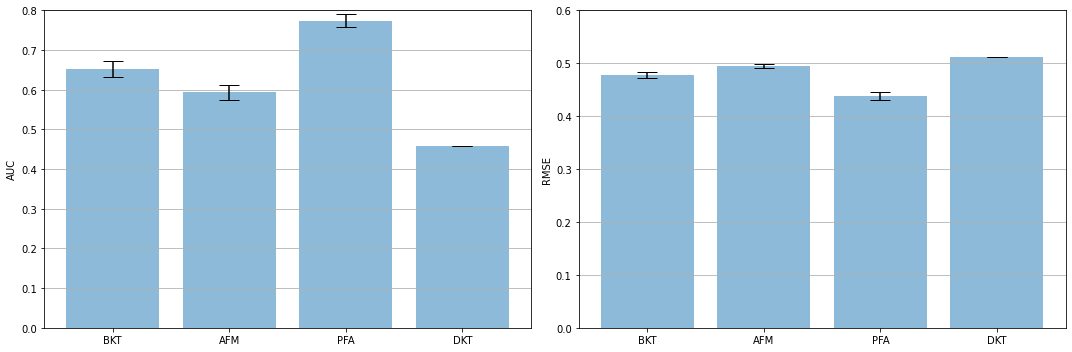

In [49]:
m = {'AUC': {'BKT': auc_bkt, 'AFM': auc_afm, 'PFA': auc_pfa, 'DKT': auc_dkt}, 'RMSE': {'BKT': rmse_bkt, 'AFM': rmse_afm, 'PFA': rmse_pfa, 'DKT': rmse_dkt}}
limits = {'AUC': 0.8, 'RMSE': 0.6}

plt.figure(figsize=(15, 5))

for metric_idx, metric_key in enumerate(m.keys()):
    
    # Create the subplot for the current metric
    plt.subplot(1, len(m), metric_idx + 1)
    # Compute means, standard deviations, and labels
    means, errors, labels = [], [], []
    for model_key, model_scores in m[metric_key].items():
        means.append(np.mean(model_scores))
        errors.append(np.std(model_scores))
        labels.append(model_key)
    
    # Plot values
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
    # Make decorations
    plt.grid(axis='y')
    plt.xticks(x_pos, labels)
    plt.ylabel(metric_key)
    plt.ylim(0, limits[metric_key])

# Show the plot
plt.tight_layout()
plt.show()

### Task 3.2 Metrics discussion

From the left plot, it can be observed that the PFA model exhibited a higher AUC score (around 0.7) with respect to AFM, PFA and DKT models and a low standard deviation of AUC score across folds, indicating that the predictive power of the PFA model is higher across folds than the one of the other three models, when AUC is considered. 

Similarly, the right plot highlights that the PFA model performs better, on average, with respect to AFM, BKT and DKT in terms of RMSE, i.e., the RMSE score is lower for the PFA model (0.47). BKT, AFM and DKT were able to achieve an average RMSE score of 0.485, 0.49 and 0.5 respectively. The standard deviation in performance across folds is quite small for all models.       

Based on our results, we can generally observe that the characteristics and properties of the PFA model allow us to make better estimations of student’s subkect mastery, compared to the three other considered models. One reason behind this finding might be that the skills at hand seem to meet well PFA assumptions, specifically that (i) studetns may initially know more or less , (ii) students learn at the same rate, (iii) students learning rate differs for correct and wrong practive opportunitites, (iv) each item belongs to one or more skills. As we can see, leveraging prior failure and success opportunities (PFA) works much better than all other models.

### Learning Curves Comparison 
----

In this section, we fit a PFA (as soon as it achieved the best performance through all other models) model on all the skills. Then, for each skill we visually report and discuss (i) the learning curve and (ii) the bar plot representing the number of students who reached a given number of opportunities for that skill,  obtained with the PFA model fitted on the above-mentioned skills, in such a way that they can be easily and appropriately compared. 

This section is divided in three main tasks:
- Task 3.3: PFA fit and prediction. 
- Task 3.4: Learning curves and bar plots generation.
- Task 3.5: Learning curves and bar plots discussion. 

### Task 3.3 Fitting model and predicting

In [50]:
%time n_succ, n_fail = read_as_success_failure(df_topic)
%time X, y = prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail)

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 134 ms
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 19.1 ms


In [51]:
# Initialize the model
pfa = CustomLogistic()

# Fit the model on the entire dataset
%time pfa.fit(X, y)

CPU times: user 9.66 s, sys: 11.8 s, total: 21.4 s
Wall time: 21.6 s


CustomLogistic()

In [52]:
# Make predictions
predictions_proba=pfa.predict_proba(X)

# Rename the dataframe columns as per instructions
predictions=df_topic[['user_id','skill_name','correct']].copy()
predictions.columns=['user_id','skill_name','y_true']
predictions['y_pred_pfa']=predictions_proba

In [53]:
predictions.head()

,user_id,skill_name,y_true,y_pred_pfa
5,387705,Comma in sanctars and supplements,0,0.29630
6,387705,Comma in sanctars and supplements,0,0.32250
7,387705,Comma in sanctars and supplements,1,0.32250
8,387705,Comma in sanctars and supplements,0,0.34987
17,387743,Comma in sanctars and supplements,0,0.40375


### Task 3.4 Learning curves visualization

In this task we visually report and discuss 

(i) the `learning curve` and 

(ii) the `bar plot` representing the number of students who reached a given number of opportunities, <br>
obtained by the PFA model fitted on that skill, in such a way that they can be easily and appropriately compared.

In [54]:
def avg_y_by_x(x, y):
    # Transform lists into arrays
    x = np.array(x)
    y = np.array(y)

    # Sort the integer id representing the number of opportunities in increasing order
    xs = sorted(list(set(x)))

    # Supporting lists to store the:
    # - xv: integer identifier of the number of opportunities
    # - yv: average value across students at that number of opportunities
    # - lcb and ucb: lower and upper confidence bound
    # - n_obs: number of observartions present at that number of opportunities (on per-skill plots, it is the #students)
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []

    # For each integer identifier of the number of opportunities 0, ...
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] # We retrieve the values for that integer identifier
        if len(ys) > 0: 
            xv.append(v) # Append the integer identifier of the number of opportunities
            yv.append(sum(ys) / len(ys)) # Append the average value across students at that number of opportunities
            n_obs.append(len(ys)) # Append the number of observartions present at that number of opportunities

            
            # Prepare data for confidence interval computation
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            # Calculate the 95% confidence intervals
            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

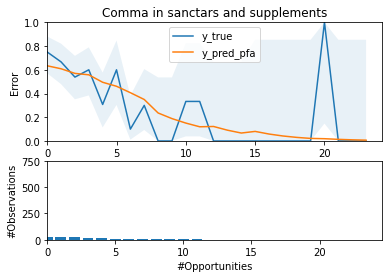

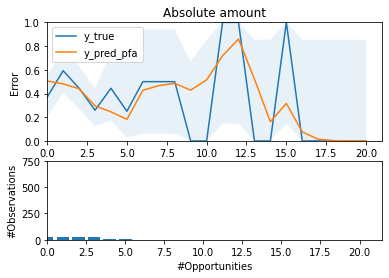

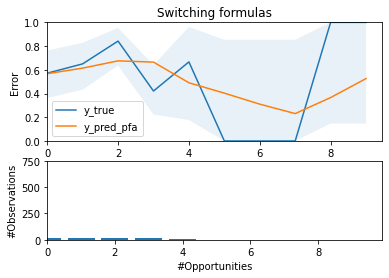

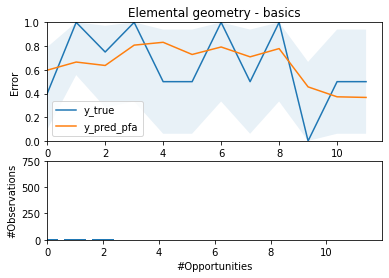

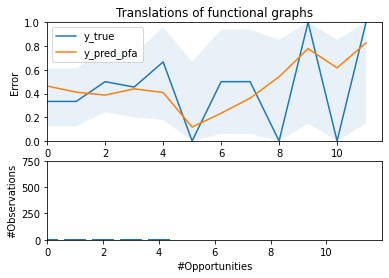

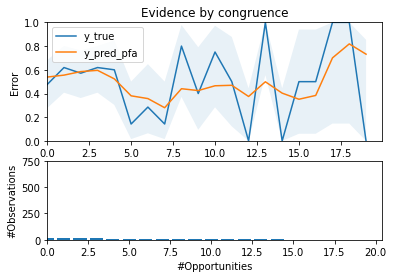

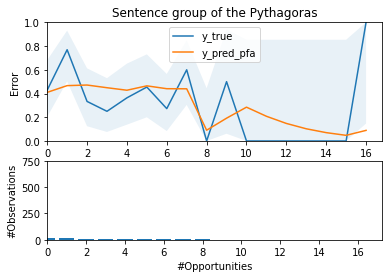

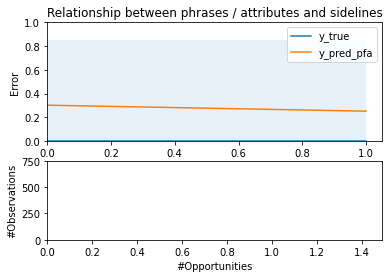

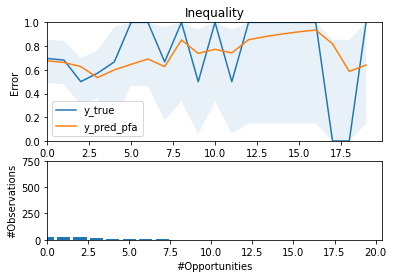

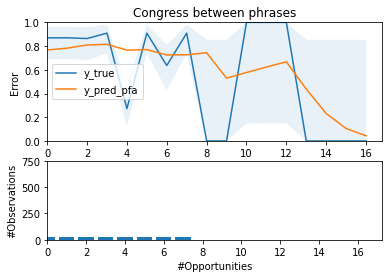

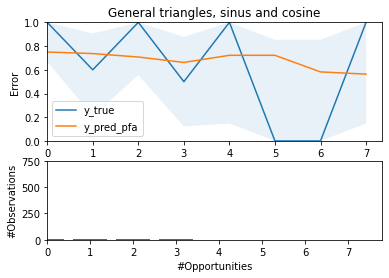

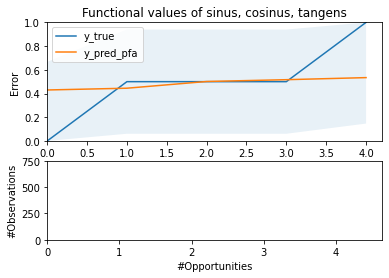

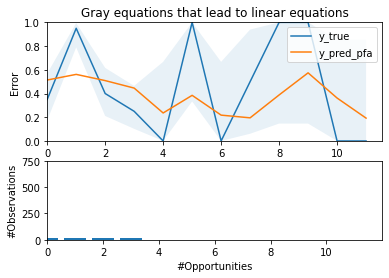

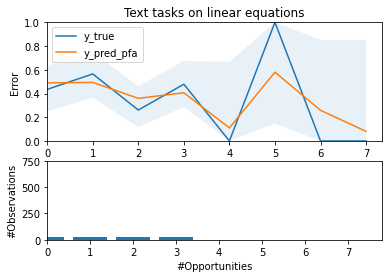

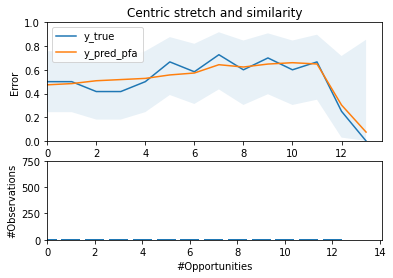

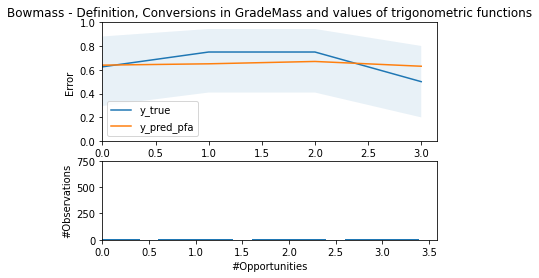

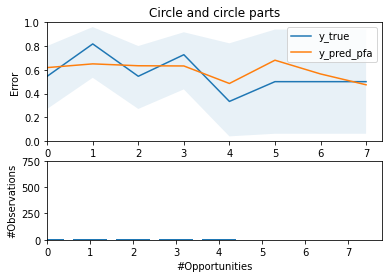

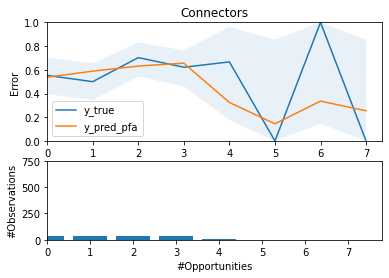

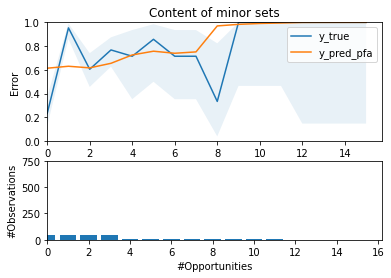

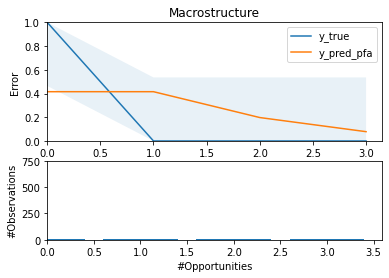

In [55]:
for plot_id, skill_name in enumerate(df_topic['skill_name'].unique()): # For each skill under consideration
    
    preds = predictions[predictions['skill_name'] == skill_name] # Retrieve predictions for the current skill

    xp = []
    yp = {}
    for col in preds.columns: # For y_true and and y_pred_pfa columns, initialize an empty list for curve values
        if 'y_' in col:
            yp[col] = []

    for user_id in preds['user_id'].unique(): # For each user
        user_preds = preds[preds['user_id'] == user_id] # Retrieve the predictions on the current skill for this user 
        xp += list(np.arange(len(user_preds))) # The x-axis values go from 0 to |n_opportunities|-1
        for col in preds.columns: 
            if 'y_' in col: # For y_true and and y_pred_pfa columns
                yp[col] += user_preds[col].tolist() # The y-axis value is the success rate for this user at that opportunity

    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}) # Initialize the plotting figure

    lines = []
    for col in preds.columns:
        if 'y_' in col: # For y_true and and y_pred_pfa columns   
            x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col]) # Calculate mean and 95% confidence intervals for success rate 
            y = [1-v for v in y] # Transform success rate in error rate
            if col == 'y_true': # In case of ground-truth data, we also show the confidence intervals
                axs[0].fill_between(x, lcb, ucb, alpha=.1)
            model_line, = axs[0].plot(x, y, label=col) # Plot the curve
            lines.append(model_line) # Store the line to then set the legend    

    # Make decorations for the learning curve plot
    axs[0].set_title(skill_name)
    axs[0].legend(handles=lines)
    axs[0].set_ylabel('Error')
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(0, None)

    # Plot the number of observations per number of opportunities bars and make decorations
    axs[1].set_xlabel('#Opportunities')
    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel('#Observations')
    axs[1].set_ylim(0, 750)
    axs[1].set_xlim(0, None)

    # Plot the learning curve and the bar plot 
    plt.show()